In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import k3d
import numpy as np
from skimage import io
from skimage.exposure import rescale_intensity
import cv2
from skimage.filters import gaussian
import ipywidgets

In [2]:
!jupyter nbextension enable --py --user k3d

Enabling notebook extension k3d/extension...
      - Validating: OK


In [ ]:
def normalize8(img):
    mn = img.min()
    mx = img.max()
    mx -= mn
    img = ((img - mn)/mx) * 2**8 - 1
    return np.round(img).astype(np.uint8) 

def pad_volume(size, volume):
    size_difference = size - volume.shape
    xr, yr, zr = ((size_difference)/2).astype(int)
    xl, yl, zl = size_difference - np.array([xr, yr, zr])
    return np.pad(volume, [[xl, xr], [yl, yr], [zl, zr]])

In [ ]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589/preps/CH1/thumbnail_aligned.25um'
fpath = os.path.join(DATA, '111.tif')
img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

In [ ]:
filepath = '/home/eddyod/.brainglobe/allen_mouse_10um_v1.2/annotation.tiff'
annotations = io.imread(filepath)

In [ ]:
SC = annotations[annotations == 302]
SC.dtype

In [ ]:
ids, counts = np.unique(SC, return_counts=True)
print(ids)
print(counts)

In [ ]:
def smooth_image(gray):
    # threshold
    thresh = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY)[1]
    # blur threshold image
    blur = cv2.GaussianBlur(thresh, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    # stretch so that 255 -> 255 and 127.5 -> 0
    stretch = rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255)).astype(np.uint8)
    # threshold again
    thresh2 = cv2.threshold(stretch, 0, 255, cv2.THRESH_BINARY)[1]
    # get external contour
    contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    # draw white filled contour on black background as mas
    contour = np.zeros_like(gray)
    cv2.drawContours(contour, [big_contour], 0, 255, -1)
    # dilate mask for dark border
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    dilate1 = cv2.morphologyEx(contour, cv2.MORPH_CLOSE, kernel)
    # apply morphology erode
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
    dilate2 = cv2.morphologyEx(dilate1, cv2.MORPH_ERODE, kernel)
    # blur dilate image
    blur2 = cv2.GaussianBlur(dilate2, (3,3), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)
    # stretch so that 255 -> 255 and 127.5 -> 0
    mask = rescale_intensity(blur2, in_range=(127.5,255), out_range=(0,255))
    #return cv2.bitwise_and(gray, gray, mask=mask.astype(np.uint8))
    return cv2.bitwise_and(gray, mask.astype(np.uint8), mask=None)
    #return dilate1


In [ ]:
arr = img.copy()
arr[arr == 255] = 0
#arr[arr == 232] = 0
plt.imshow(arr, cmap='gray')

In [ ]:
simg = img.copy()
simg[simg == 255] = 0
smooth_img = smooth_image(simg)
plt.imshow(smooth_img, cmap='gray')

In [ ]:
def merge_volumes(volumes):
    sizes = np.array([vi.shape for vi in volumes])
    volume_size = sizes.max(0) + 5
    
    volumes = [pad_volume(volume_size, vi) for vi in volumes]
    volumes = list([(v > 0).astype(np.int32) for v in volumes])
    merged_volume = np.sum(volumes, axis=0)
    #merged_volume_prob = merged_volume / float(np.max(merged_volume))
    merged_volume_prob = merged_volume / float(len(volumes))
    # increasing the STD makes the volume smoother
    # Smooth the probability
    average_volume = gaussian(merged_volume_prob, 1.0)
    color = 1
    #average_volume = merged_volume_prob
    average_volume[average_volume > 0.3] = color
    average_volume[average_volume != color] = 0
    average_volume = average_volume.astype(np.uint8)
    return average_volume

def merge_brain(volumes):
    #sizes = np.array([vi.shape for vi in volumes])
    #volume_size = sizes.max(0) + 5
    
    #volumes = [pad_volume(volume_size, vi) for vi in volumes]
    #volumes = list([(v > 0).astype(np.int32) for v in volumes])
    merged_volume = np.sum(volumes, axis=0)
    #merged_volume_prob = merged_volume / float(np.max(merged_volume))
    average_volume = merged_volume / float(len(volumes))
    average_volume = normalize8(average_volume)
    # increasing the STD makes the volume smoother
    # Smooth the probability
    #average_volume = gaussian(merged_volume_prob, 1.0)
    #color = 1
    #average_volume = merged_volume_prob
    #average_volume[average_volume > 0.3] = color
    #average_volume[average_volume != color] = 0
    #average_volume = average_volume.astype(np.uint8)
    return average_volume



In [ ]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
structure = '7n_L'
for brain in brains:
    structure_path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{brain}'
    volume_path = os.path.join(structure_path, 'structure', f'{structure}.npy')
    volume = np.load(volume_path)
    volumes.append(volume)
    print(volume.shape)


In [ ]:
brains = ['MD589_25um_sagittal.tif', 'MD585_MD589.tif', 'MD594_MD589.tif']
volumes = []
fixed_path = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
for brain in brains:
    brainpath = os.path.join(fixed_path, brain)
    brainimg = io.imread(brainpath)
    if brainimg.dtype == np.uint8:
        #brainimg = normalize8(brainimg)
        brainimg = brainimg.astype(np.float32)
    print(brain, brainimg.shape, brainimg.dtype)
    volumes.append(brainimg)

In [ ]:
merged_volume = merge_volumes(volumes)
print(merged_volume.dtype)

In [23]:
# Full data structures look much better.
structure = '7n_L'
structure_path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/MD594/structure'
volume_path = os.path.join(structure_path, f'{structure}.npy')
volume = np.load(volume_path)
volume = gaussian(volume, 1)
print(f'volume dtype={volume.dtype} shape={volume.shape}')

volume dtype=float64 shape=(46, 46, 50)


In [24]:
new_volume = volume.copy()
new_volume[new_volume > 0] = 255
ids, counts = np.unique(new_volume, return_counts=True)
print(f'volume dtype={volume.dtype} shape={volume.shape}')
print(ids)
print(counts)

volume dtype=float64 shape=(46, 46, 50)
[  0. 255.]
[80436 25364]


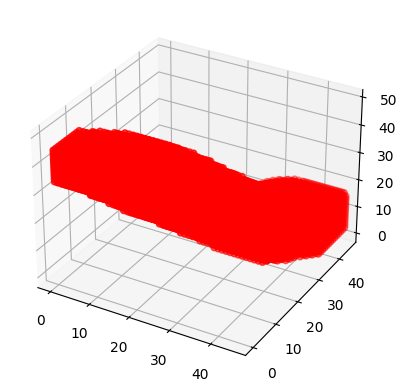

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = new_volume.nonzero()
ax.scatter(x, y, z, zdir='y', c= 'red')
plt.show()

In [4]:
plt_volume = k3d.volume(volume.astype(np.float32))
plot = k3d.plot()
plot += plt_volume
plot.display()

Output()